# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

from astropy.io import fits


np.set_printoptions(threshold=np.nan)


import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files. For checks with original code, we need to construct `eleceng` and `photeng` in the same way.

In [4]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng = np.sqrt(photenglow*photenghigh)


In [5]:
# eleceng = 10**np.arange(0, 12, 0.024)
# photeng = 10**np.arange(-2, 12, 0.028)
T = phys.TCMB(1000)

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

print(eleceng.size, photeng.size)

500 500


Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

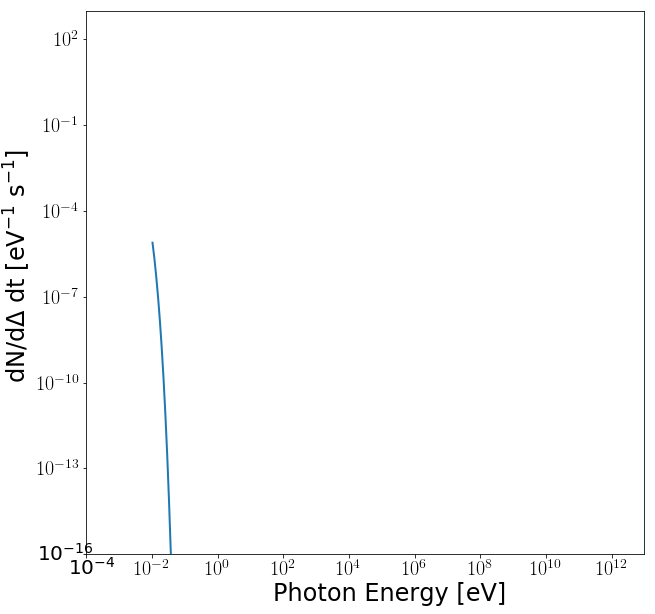

In [6]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
# comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

# engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
engloss_tf.plot(ax, ind=3, indtype='ind', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [7]:
engloss_tf[3].totN('bin')

array([  5.14739165e-09,   3.01527044e-09,   1.69540657e-09,
         9.04550424e-10,   4.55879403e-10,   2.18391048e-10,
         9.91894879e-11,   4.25980950e-11,   1.68021527e-11,
         6.20411862e-12,   2.13726242e-12,   6.84506760e-13,
         1.99682059e-13,   5.26323034e-14,   1.26745182e-14,
         2.77569166e-15,   5.50188979e-16,   9.37155721e-17,
         1.41915448e-17,   1.89899366e-18,   2.23138749e-19,
         2.21974213e-20,   1.84275693e-21,   1.30210744e-22,
         7.76702357e-24,   3.87801558e-25,   1.47732622e-26,
         4.56225487e-28,   1.12978812e-29,   2.21855781e-31,
         3.23626281e-33,   3.41797495e-35,   2.70736553e-37,
         1.58479695e-39,   6.75259045e-42,   1.77496010e-44,
         3.20718297e-47,   3.90697164e-50,   3.14528245e-53,
         1.48915362e-56,   3.96066106e-60,   6.30179999e-64,
         5.84239984e-68,   3.07182995e-72,   6.81659628e-77,
         7.74509808e-82,   4.35219246e-87,   1.16710440e-92,
         1.21278561e-98,

In [8]:
sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

[0.0001, 1000000000000.0, 1e-16, 1000.0]

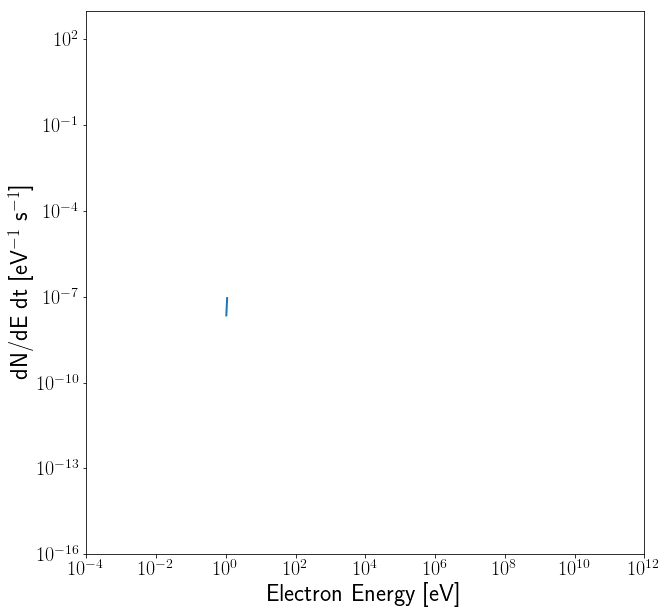

In [9]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
# comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

# sec_elec_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)
sec_elec_tf.plot(ax, ind=1, indtype='ind', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e12, 1e-16, 1e3])

In [10]:
print(sec_elec_tf.get_eng())
sec_elec_tf[30].totN('bin')

[  1.02801630e+00   1.08642562e+00   1.14815362e+00   1.21338885e+00
   1.28233058e+00   1.35518941e+00   1.43218790e+00   1.51356125e+00
   1.59955803e+00   1.69044093e+00   1.78648757e+00   1.88799135e+00
   1.99526231e+00   2.10862815e+00   2.22843515e+00   2.35504928e+00
   2.48885732e+00   2.63026799e+00   2.77971327e+00   2.93764965e+00
   3.10455959e+00   3.28095293e+00   3.46736850e+00   3.66437575e+00
   3.87257645e+00   4.09260660e+00   4.32513831e+00   4.57088190e+00
   4.83058802e+00   5.10505000e+00   5.39510623e+00   5.70164272e+00
   6.02559586e+00   6.36795521e+00   6.72976656e+00   7.11213514e+00
   7.51622894e+00   7.94328235e+00   8.39459987e+00   8.87156012e+00
   9.37562007e+00   9.90831945e+00   1.04712855e+01   1.10662378e+01
   1.16949939e+01   1.23594743e+01   1.30617089e+01   1.38038426e+01
   1.45881426e+01   1.54170045e+01   1.62929603e+01   1.72186857e+01
   1.81970086e+01   1.92309173e+01   2.03235701e+01   2.14783047e+01
   2.26986485e+01   2.39883292e+01

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   4.55962233e-63,   8.76750713e-08,
         1.92757154e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [11]:
pri_elec = np.array([spec.totN() for spec in sec_elec_tf])
pri_elec *= sec_elec_tf.get_in_eng()
sec_elec = np.array([spec.toteng() for spec in sec_elec_tf])
sec_phot = np.array([spec.toteng() for spec in ICS_tf])
CMB_phot = phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c*np.ones_like(sec_phot)

utils.compare_arr([pri_elec, sec_elec, sec_phot, CMB_phot])

# print(c - phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c)
# print(a-b-c+phys.CMB_eng_density(T)*phys.thomson_xsec*phys.c)

[[ 5.1185384e-09  5.0634459e-09  0.0051861998  0.0051966997]
 [ 7.2178155e-09  7.1441031e-09  0.0051862014  0.0051966997]
 [ 1.0109722e-08  1.0011749e-08  0.0051862031  0.0051966997]
 [ 1.4081103e-08  1.39516e-08  0.0051862048  0.0051966997]
 [ 1.9404607e-08  1.9235232e-08  0.0051862067  0.0051966997]
 [ 2.6575945e-08  2.6355763e-08  0.0051862087  0.0051966997]
 [ 3.6211272e-08  3.5926473e-08  0.0051862108  0.0051966997]
 [ 4.8857417e-08  4.8492618e-08  0.005186213  0.0051966997]
 [ 6.5547497e-08  6.5082814e-08  0.0051862154  0.0051966997]
 [ 8.7527402e-08  8.693818e-08  0.0051862178  0.0051966997]
 [ 1.1582336e-07  1.1508292e-07  0.0051862205  0.0051966997]
 [ 1.5247308e-07  1.515473e-07  0.0051862232  0.0051966997]
 [ 1.9986142e-07  1.987087e-07  0.0051862261  0.0051966997]
 [ 2.5979785e-07  2.5837441e-07  0.0051862292  0.0051966997]
 [ 3.3610675e-07  3.343571e-07  0.0051862325  0.0051966997]
 [ 4.3313251e-07  4.3098996e-07  0.0051862359  0.0051966997]
 [ 5.5388293e-07  5.5127919e-07

0

In [202]:
# %%prun
sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1)
sec_phot_tf.rs = ICS_tf.rs
lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1)
lowengelec_tf.rs = ICS_tf.rs
elec_high_eng = eleceng[eleceng > 3000]
elec_low_eng  = eleceng[eleceng <= 3000]

highengelec_ind = np.arange(eleceng.size)[eleceng > 3000]
lowengelec_ind  = np.arange(eleceng.size)[eleceng <= 3000]

elec_high_eng_bin_width = spectools.get_log_bin_width(elec_high_eng)
photeng_bin_width = spectools.get_log_bin_width(photeng)


ICS_tf_high_eng = tf.TransFuncAtRedshift(
    ICS_tf[highengelec_ind[0]:], dlnz=-1)

sec_elec_tf_high_eng = sec_elec_tf.at_val(
    highengelec_ind, highengelec_ind, interp_type='bin'
)

sec_elec_tf_low_eng = sec_elec_tf.at_val(
    highengelec_ind, lowengelec_ind, interp_type='bin'
)

delta_spec = np.zeros_like(elec_high_eng)
for i,eng in zip(np.arange(elec_high_eng.size), elec_high_eng):
    delta_spec *= 0
    delta_spec[i] = 1  
    sec_phot_spec_N = spectools.scatter(ICS_tf_high_eng, mode='N', out_mode='N',
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=photeng)
    sec_elec_spec_N = spectools.scatter(sec_elec_tf_high_eng, mode='N', out_mode='N',
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_high_eng)
    # Total energy of primary electrons scattered in 1 second
    pri_elec_toteng = np.sum(sec_elec_spec_N*eng)
#     # Total energy in secondary photon spectrum
    sec_phot_toteng = np.sum(sec_phot_spec_N*photeng*photeng_bin_width)
#     # Total energy in secondary electron spectrum
    sec_elec_toteng = np.sum(sec_elec_spec_N*elec_high_eng*elec_high_eng_bin_width)
#     # Total energy of the CMB photons that were upscattered. 
    scattered_CMB_toteng = phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)

    sec_lowengelec_spec = spectools.scatter(sec_elec_tf_low_eng, mode='N', out_mode='dNdE',
                                            eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_low_eng)
    sec_lowengelec_spec.in_eng = eng
    if sec_phot_tf.spec_arr and i > 0:
        rescatter_spec_N = sec_elec_spec_N[0:i]
        # normalize to one secondary
#         rescatter_spec_N /= np.sum(rescatter_spec_N)
        sec_phot_spec_N += spectools.scatter(sec_phot_tf, mode='N', out_mode='N', 
                                          eng_arr = elec_high_eng[0:i], N_arr = rescatter_spec_N, new_eng = photeng)
    
#  sec_phot_spec_N is the total photon spectrum after 1 second due to 
#  scattering of 1 electron.
#     sec_phot_spec_N /= sec_phot_toteng*(pri_elec_toteng - sec_elec_toteng + scattered_CMB_toteng)
# Normalized to the correct dE_gamma/dt for incoming primary energy loss rate. 
#     sec_phot_spec_N_toteng = np.sum(sec_phot_spec_N*photeng*photeng_bin_width)
#     sec_phot_spec_N = sec_phot_spec_N/sec_phot_spec_N_toteng*(1 + scattered_CMB_toteng/pri_elec_toteng)*eng
    sec_phot_spec = spectools.rebin_N_arr(sec_phot_spec_N, photeng)
    sec_phot_spec.in_eng = eng
    sec_phot_spec.rs = ICS_tf.rs
    
#     if eng + phys.me < 20*phys.me:
#         eng_in_sec_phot = eng - sec_phot_spec.toteng() + phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)
#     else:
#         eng_in_sec_phot = eng - sec_phot_spec.toteng()
    
#     sec_phot_spec_norm = sec_phot_spec*eng_in_sec_phot/sec_phot_spec.toteng()
#     if i == 2:
#         utils.compare_arr([sec_phot_spec.dNdE, sec_phot_spec_norm.dNdE])
    if eng + phys.me > 20*phys.me:
        sec_phot_spec = sec_phot_spec/sec_phot_spec.toteng()*eng
    else:
        sec_phot_spec = sec_phot_spec/sec_phot_spec.toteng()*eng
    # This is not correct for below 20*phys.me
    sec_phot_tf.append(sec_phot_spec)
#     lowengelec_tf.append(sec_lowengelec_spec)

        
        
    

In [203]:
ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

[0.0001, 10000000000000.0, 1e-16, 10000000000.0]

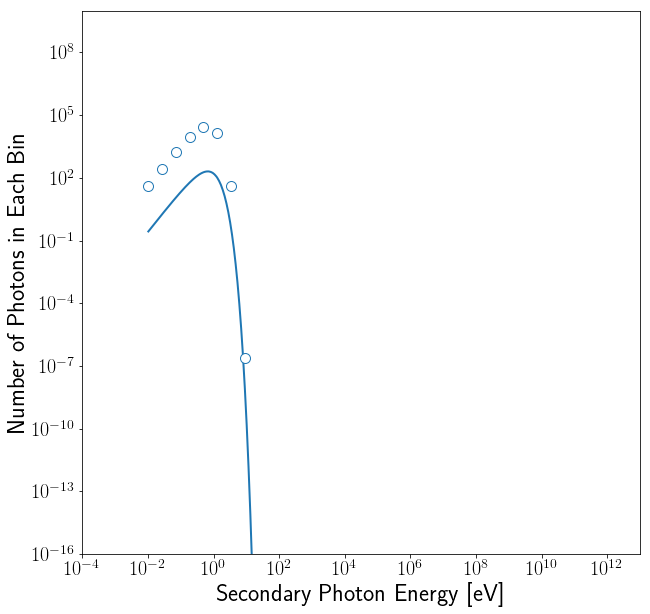

In [205]:
log_bin_width = spectools.get_log_bin_width(sec_phot_tf.get_eng())


ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([3.5e3])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

ICS_test_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, marker='o', markersize='10', 
    markerfacecolor='w', markevery=15,)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Secondary Photon Energy [eV]',fontsize=24)

plt.ylabel('Number of Photons in Each Bin',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e10])

In [189]:
print(sec_phot_tf.at_in_eng([3500])[0].toteng())
print(ICS_test_tf.at_in_eng([3500])[0].toteng())
print(sec_phot_tf.get_in_eng()[0])
print(ICS_test_tf.get_in_eng()[0])
print(ICS_test_tf[10].dNdE)

3506.95343272
29521.4211844
3104.55958813
1.02801629813
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [48]:
sec_phot_tf[100].totN('bin')
utils.compare_arr([sec_phot_tf.get_in_eng(), ICS_test_tf.get_in_eng()])

ValueError: all input arrays must have the same shape

In [152]:
print(eleceng[0])

1.02801629813
